### **Imports**

In [1]:
import numpy as np
import neurodesign
import matplotlib.pyplot as plt

In [2]:
import os
# Since Neurodesign uses multi-threading internally, limit the number of threads
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

### **Defining an Experiment**

#### Experiment Parameters

The following parameters are used to initialize the `neurodesign.Experiment` class.

| Parameter | Example Value | Description |
| :--- | :--- | :--- |
| **`TR`** | `2` | Repetition time of fMRI acquisition in seconds. |
| **`n_trials`** | `20` | Number of trials in the experiment (short toy example). |
| **`P`** | `[0.25, 0.25, 0.25, 0.25]` | Probability of occurrence for each condition. |
| **`C`** | `[[1,0,-1,0], [1,0,0,-1], [0,1,-1,0], [0,1,0,-1]]` | Contrast matrix defining comparisons between conditions (e.g., C1 vs C3). |
| **`n_stimuli`** | `4` | Total number of unique stimulus conditions. |
| **`rho`** | `0.3` | Temporal autocorrelation coefficient for fMRI noise. |
| **`stim_duration`** | `1` | Duration of each stimulus event in seconds. |
| **`t_pre`** | `0.5` | Duration of the pre-stimulus baseline (e.g., fixation) in seconds. |
| **`t_post`** | `2` | Duration of the post-stimulus period (e.g., feedback) in seconds. |
| **`ITImodel`** | `"exponential"` | The statistical model used to sample Inter-Trial Intervals (ITI). |
| **`ITImin`** | `1` | Minimum allowed duration for an ITI in seconds. |
| **`ITImax`** | `4` | Maximum allowed duration for an ITI in seconds. |
| **`ITImean`** | `2.1` | Mean duration of the ITI distribution in seconds. |

Notice in the following example, we have 4 stimuli, thus we have 4 entries in the P array, assigning a probability to each stimuli. 

The baseline, ITI model is used to calculate the intertrial interval between any pair of stimuli (in modification tutorial, we will see how to customize the ITI for each case)

Another key thing to notice here is that all of the stimuli have the same stimuli duration denoted as **stim_duration.**

In [3]:
exp = neurodesign.Experiment(
    TR=2,                        # Repetition time (TR) of fMRI acquisition in seconds
    n_trials=20,                 # Number of trials (short toy example)
    P=[0.25, 0.25, 0.25, 0.25],           # Condition probabilities: Condition 2 is slightly overrepresented
    C=[[1,0, -1, 0],[1, 0, 0, -1], [0, 1, -1, 0],  [0, 1, 0,-1]],  # Contrasts: C1 vs C3, C1 vs C4
    n_stimuli=4,                 # Total number of stimulus conditions
    rho=0.3,                     # Temporal autocorrelation in fMRI noise
    stim_duration=1,            # Duration of each stimulus (in seconds)
    t_pre=0.5,                  # Pre-stimulus baseline (e.g., fixation)
    t_post=2,                   # Post-stimulus period (e.g., feedback)
    ITImodel="exponential",     # Inter-trial interval (ITI) sampling model
    ITImin=1,                   # Minimum ITI
    ITImax=4,                   # Maximum ITI
    ITImean=2.1,                # Mean ITI
)

/Users/atharvumap/Documents/Projects/neurodesign_refactored/.venv/lib/python3.13/site-packages/neurodesign/classes.py:638: UserWarning: the resolution is adjusted to be a multiple of the TR. New resolution: 0.1
  warnings.warn(
/Users/atharvumap/Documents/Projects/neurodesign_refactored/.venv/lib/python3.13/site-packages/neurodesign/classes.py:822: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.19859016e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.24333304e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.08746121e-01  2.78856076e-05  0.00000000e+00  0.00000000e+00]
 [ 1.50213325e-01  4.82662401e-02  0.00000000e+00  0.00000000e+00]
 [ 6.76055106e-02  1.87871688e-01  0.00000000e+00  0.00000000e+00]
 [ 2.38565667e-02  1.90041761e-01  0.00000000e+00  0.00000000e+00]
 [ 1.22504817e-01  1.06224353e-01  0.00000000e+00  0.00000000e+00]
 [ 1.90259301e-01  3.80370258e-02  0.00000000e+00  0.00000000e+00]
 [ 1.28374793e-01  7.73491836e-02  0.00000000e+00  0.00000000e+00]
 [ 5.14635722e-02  1.86382601e-01  0.00000000e+00  0.00000000e+00]
 [ 6.01752698e-03  1.56978706e-01  1.37585098e-02  0.00000000e+00]
 [-1.43980866e-02  7.45576779e-02  1.46787664e-01  0.00000000e+00]
 [-2.02242359e-02  1.76751189e-02  2.06554767e-01  2.71005447e-07]
 [-1.80655612e-02 -9.87236103e-03  1.36868912e-01  3.06085361e

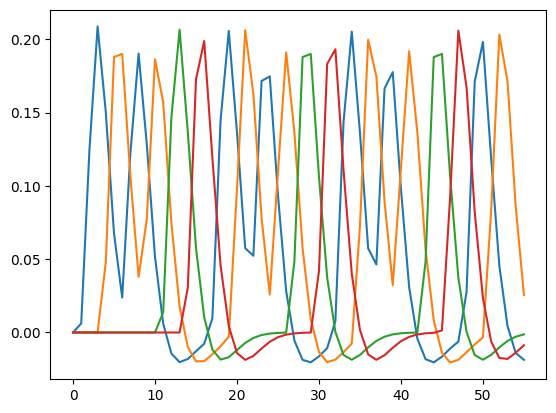

In [4]:
# In this design I am manually creating the order and the onsets
order=[0, 1, 0, 1, 2, 3] * 3

design = neurodesign.Design(
    order=order + [0, 1],  # Repeating sequence of conditions (C0, C1, C0, C1, C2, C3)
    ITI = neurodesign.generate.iti(                   # ITIs drawn from exponential distribution
        ntrials=20, 
        model="exponential", 
        min=1, 
        mean=2, 
        max=4, 
        seed=1234
    )[0],             
    experiment=exp,
    # onsets = onsets
)

# Compute the convolved design matrix and evaluate design quality
design.designmatrix()
print(design.Xconv)
plt.plot(design.Xconv)

In [5]:
population = neurodesign.Optimisation(
    experiment=exp,
    R=[1, 0, 0], # 100% blocked, 0% random, 0% msequence
    weights=[0, 0.5, 0.25, 0.25],  # Weights for Fe, Fd, confounding, and frequency
    preruncycles=10,               # Warm-up iterations
    cycles=100,                    # Main genetic algorithm iterations
    folder="./",                   # Output folder for results
    seed=100                       # Seed for reproducibility
)

population.optimise()             # Run the optimization

/Users/atharvumap/Documents/Projects/neurodesign_refactored/.venv/lib/python3.13/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [6]:
best_design = population.bestdesign  # The best subject from the final generation

print(f"Fd (detection efficiency): {best_design.Fd}")
print(f"Ff (estimation efficiency): {best_design.Ff}")
print(f"Fc (confounding): {best_design.Fc}")
print(f"Fe (stimulus frequency balance): {best_design.Fe}")

Fd (detection efficiency): 1.0279382872267064
Ff (estimation efficiency): 1.0
Fc (confounding): 0.6781214203894617
Fe (stimulus frequency balance): 0
